In [7]:
import torch
import json
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

from pandas.plotting import scatter_matrix
from scipy.spatial import distance
from scipy.stats import percentileofscore



/!\ Disclaimer: it is possible that dataframes indices are treated as integers instead of strings (or the opposite) in this notebook depending on how you import the data

The aim of this notebook is to look at the position of a nearest neighbour in another latent space (constructed with the same data):

- take a vector idx in a latent space A and find its nearest neighbour (nn)
- calculate the distance between idx and nn in a latent space B. (B is supposed to contain the representation of the same elements than in A.)
- rank nn in terms of distance to idx in B (it is first if it is still the closest to idx in B and last if it is the furthest)
- do stats on that

This is a proxy to see if the structure of a latent space is conserved from one to another (a couple of points that are close in a latent space souldn't be too far in the other one).

# Load the data

In [5]:
def load_embeddings(verbose=False):    
    # load embeddings
    dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/pca"
    path1 = dir_path + "/pca_embeddings_4.csv"
    path2 = dir_path + "/pca_embeddings_4_bis.csv"

    embeddings1 = pd.read_csv(path1, index_col=0)
    embeddings2 = pd.read_csv(path2, index_col=0)

    if verbose:
        print(embeddings1.head())
        print(embeddings2.head())

        print((embeddings1.index == embeddings2.index).all())

    return embeddings1, embeddings2

embeddings1, embeddings2 = load_embeddings(verbose=True)

                    dim1        dim2        dim3        dim4
Subject                                                     
1-03HUBJO_t0  -53.581267  283.678938 -289.063502  -39.672054
1-08ANDTI_t0  304.418742  221.742303  211.783481   33.349747
1-11LEBJO_t0  229.578929  287.441938   26.521953 -121.054115
1-15LEHMI_t0  111.159597    3.504305  -62.448512  -17.323040
1-17COLMA_t0 -155.809363 -150.642347 -204.869352 -183.737926
                    dim1        dim2        dim3        dim4
Subject                                                     
1-03HUBJO_t0  -53.573183  283.652352 -288.934731  -39.502829
1-08ANDTI_t0  304.417736  221.756600  211.825676   33.274134
1-11LEBJO_t0  229.579421  287.442137   26.664879 -120.474304
1-15LEHMI_t0  111.148563    3.533237  -62.669223  -17.656209
1-17COLMA_t0 -155.803638 -150.661495 -204.716931 -183.198089
True


# Plot the scatter matrices of the two df

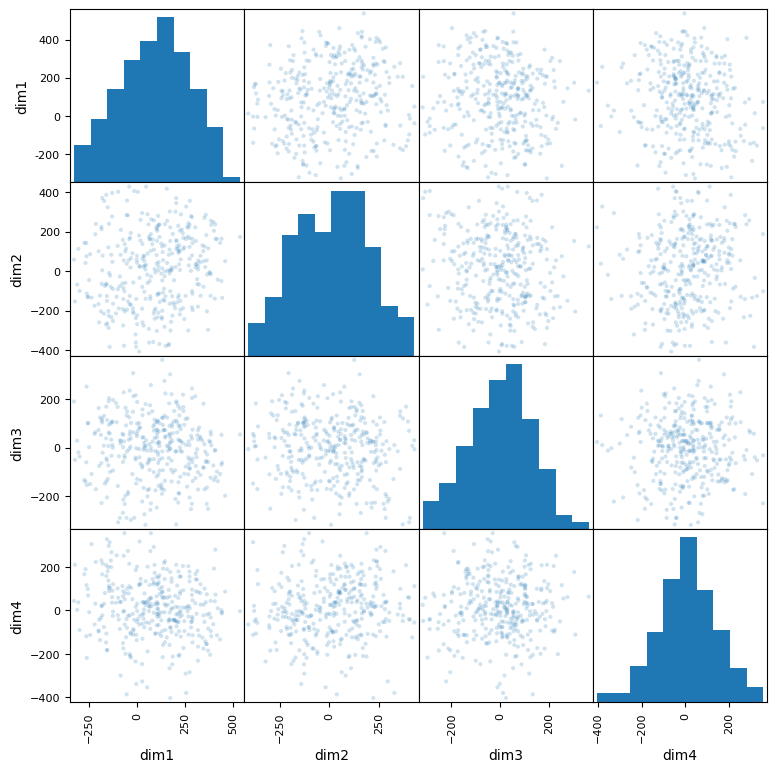

In [8]:
sm1 = scatter_matrix(embeddings1[["dim1", "dim2", "dim3", "dim4"]], alpha=0.2, figsize=(9,9))

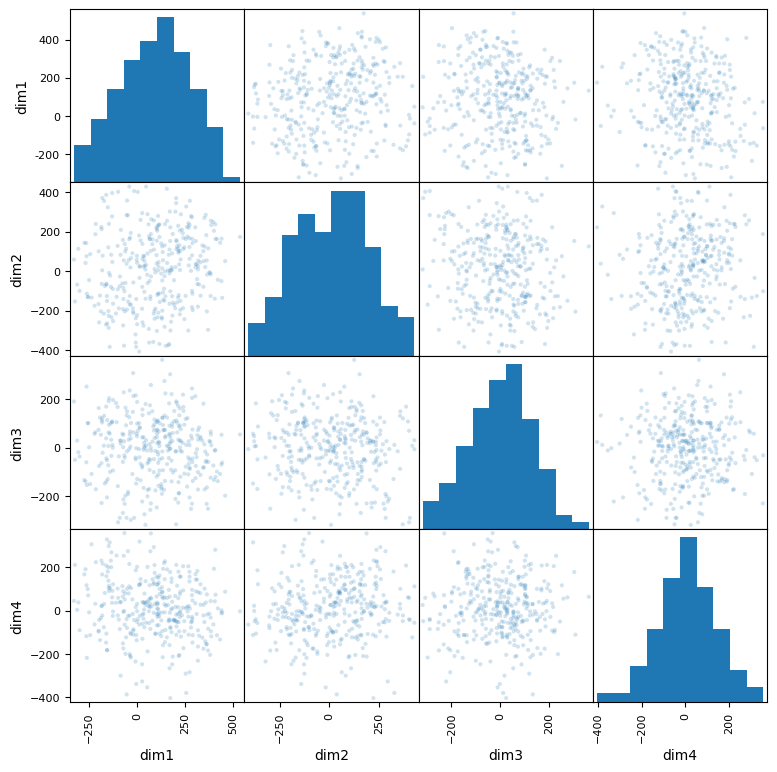

In [9]:
sm2 = scatter_matrix(embeddings2[["dim1", "dim2", "dim3", "dim4"]], alpha=0.2, figsize=(9,9))

# Get the nearest neighbour

In [10]:
# tests distance.euclidian
line1 = embeddings1.iloc[1,:]
line2 = embeddings1.iloc[2,:]
print(line1)
print(line2)

print(distance.euclidean(line1, line2))

embeddings1.apply(distance.euclidean, axis=1, args=[np.array(line1)])

dim1    304.418742
dim2    221.742303
dim3    211.783481
dim4     33.349747
Name: 1-08ANDTI_t0, dtype: float64
dim1    229.578929
dim2    287.441938
dim3     26.521953
dim4   -121.054115
Name: 1-11LEBJO_t0, dtype: float64
260.92111046812096


Subject
1-03HUBJO_t0                            623.040959
1-08ANDTI_t0                              0.000000
1-11LEBJO_t0                            260.921110
1-15LEHMI_t0                            403.420175
1-17COLMA_t0                            755.782295
                                           ...    
sub-inhibition25_ses-pretraining_T1w    434.294147
sub-inhibition26_ses-pretraining_T1w    782.149460
sub-inhibition28_ses-pretraining_T1w    401.397245
sub-inhibition29_ses-pretraining_T1w    343.242531
sub-inhibition31_ses-pretraining_T1w    481.456075
Length: 341, dtype: float64

In [11]:
# get the nearest neighbour of a line of the dataset df
# returns the label of the nn and its distance to the line
def get_nearest_neighbour(line, df, dist=distance.euclidean):
    idx = line.name
    df_without_line = df[df.index != idx]
    distances = df_without_line.apply(dist, axis=1, args=[np.array(line)]).to_frame()
    nn = distances.idxmin()[0]
    min_dist = distances[0][nn]
    return [nn, min_dist]

In [12]:
get_nearest_neighbour(line1, embeddings1)

['nih_chp_05627_t1', 115.67911111506314]

In [13]:
# get the nearest neighbours and their distance for the first run

nearest_neighbours1 = embeddings1.apply(get_nearest_neighbour, axis=1, result_type='expand', 
                                          args=[embeddings1])
embeddings1['nn'] = nearest_neighbours1[0]
embeddings1['min_dist'] = nearest_neighbours1[1]
embeddings1

,dim1,dim2,dim3,dim4,nn,min_dist
Subject,,,,,,
1-03HUBJO_t0,-53.581267,283.678938,-289.063502,-39.672054,sub-active25_ses-pretraining_T1w,127.643379
1-08ANDTI_t0,304.418742,221.742303,211.783481,33.349747,nih_chp_05627_t1,115.679111
1-11LEBJO_t0,229.578929,287.441938,26.521953,-121.054115,e0064_anat_t1_s03,79.012839
1-15LEHMI_t0,111.159597,3.504305,-62.448512,-17.323040,nih_chp_04584_t1,83.220334
1-17COLMA_t0,-155.809363,-150.642347,-204.869352,-183.737926,nih_chp_05069_t1,108.322341
...,...,...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,170.166648,-165.182574,90.018875,-44.433941,nih_chp_04767_t1,65.554955
sub-inhibition26_ses-pretraining_T1w,-3.713930,-383.404866,-147.696925,-112.878761,sub-inhibition07_ses-pretraining_T1w,92.809136
sub-inhibition28_ses-pretraining_T1w,35.005014,22.359858,-9.068795,35.977370,sub-active08_ses-pretraining_T1w,11.418303


In [14]:
# get the nearest neighbours and their distance for the second run

nearest_neighbours2 = embeddings2.apply(get_nearest_neighbour, axis=1, result_type='expand',
                                          args=[embeddings2])
embeddings2['nn'] = nearest_neighbours2[0]
embeddings2['min_dist'] = nearest_neighbours2[1]
embeddings2

,dim1,dim2,dim3,dim4,nn,min_dist
Subject,,,,,,
1-03HUBJO_t0,-53.573183,283.652352,-288.934731,-39.502829,sub-active25_ses-pretraining_T1w,127.696183
1-08ANDTI_t0,304.417736,221.756600,211.825676,33.274134,nih_chp_05627_t1,115.408763
1-11LEBJO_t0,229.579421,287.442137,26.664879,-120.474304,e0064_anat_t1_s03,78.960379
1-15LEHMI_t0,111.148563,3.533237,-62.669223,-17.656209,nih_chp_04584_t1,83.532633
1-17COLMA_t0,-155.803638,-150.661495,-204.716931,-183.198089,nih_chp_05069_t1,108.322733
...,...,...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,170.162427,-165.145988,90.230718,-45.259759,nih_chp_04767_t1,65.472725
sub-inhibition26_ses-pretraining_T1w,-3.713562,-383.411636,-147.690862,-113.069668,sub-inhibition07_ses-pretraining_T1w,92.800510
sub-inhibition28_ses-pretraining_T1w,35.005033,22.356712,-9.048449,35.859019,sub-active08_ses-pretraining_T1w,11.425243


In [10]:
"""# save embeddings 1 and 2 as csv files
embeddings1.to_csv("embeddings_05-10.csv")
embeddings2.to_csv("embeddings_05-11.csv")"""

# Get distance matrices

In [15]:
def get_distance_matrix(emb, verbose=False):
    # emb should not have the nn nor the min_dist columns    
    dist_mat = pd.DataFrame()

    for idx in emb.index:
        line = emb[emb.index == idx]
        if verbose:
            print(line)
        distances = emb.apply(distance.euclidean, axis=1, args=[np.array(line)])
        dist_mat[idx] = distances

    return dist_mat

In [21]:
# reload the original files for them not to have the 'nn' and 'min_dist' columns
#embeddings1, embeddings2 = load_embeddings()

# generate the distance matrices
dist_mat1 = get_distance_matrix(embeddings1[["dim1", "dim2", "dim3", "dim4"]])
dist_mat2 = get_distance_matrix(embeddings2[["dim1", "dim2", "dim3", "dim4"]])

# save the distance matrices
# dist_mat1.to_csv("distance_mat_05-10.csv")
# dist_mat2.to_csv("distance_mat_05-11.csv")

# NN analysis

In [13]:
# load the tables with the 'nn' and 'min_dist' columns
embeddings1 = pd.read_csv("embeddings_05-10.csv", index_col=0)
embeddings2 = pd.read_csv("embeddings_05-11.csv", index_col=0)

### Calculate the proportion of nn that are still nn in the other latent space

In [16]:
def nearest_neighbours_conservation(emb1, emb2):
    # emb1 and emb2 should contain the nn column already
    if False in (emb1.index == emb2.index):
        raise ValueError("emb1 and emb2 should contain the same elements")
    else:
        same_nn = (emb1.nn == emb2.nn)
        return same_nn, same_nn.mean()
        

In [17]:
same_nn, ratio = nearest_neighbours_conservation(embeddings1, embeddings2)
# ratio of vectors that keep their nn
print(same_nn.sum(),"elements,",ratio*100, "% of the dataset")


339 elements, 99.41348973607037 % of the dataset


In [18]:
# list of vectors that keep their nn (+ their nn in the 2nd column)
embeddings1[same_nn != True]['nn']

Subject
a0006_t1_s03        nih_chp_03811_t1
nih_chp_03202_t1        a0017_t1_s03
Name: nn, dtype: object

### Visualisation of single nearest neighbour position in the other latent space

rand_idx nih_chp_05261_t1
nearest_neighbours: 2-11TREVA_t0 2-11TREVA_t0

0.5865102639296188%, 2-th element


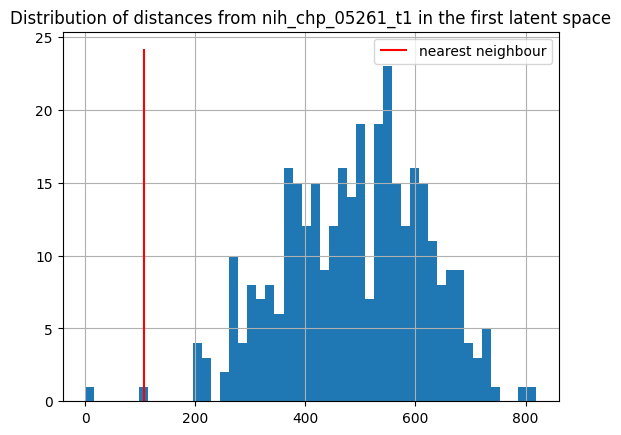

0.5865102639296188%, 2-th element


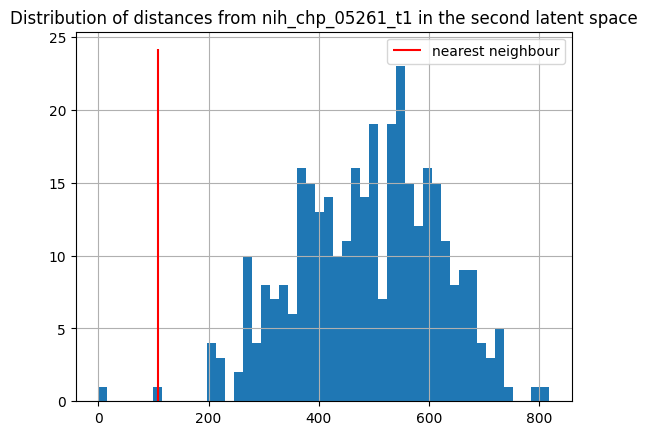

In [22]:
# choose a random index
rand_idx = rd.choice(embeddings1.index)
print("rand_idx", rand_idx)

# get the nn of rand_idx for both latent spaces
nn1 = str(embeddings1.nn[rand_idx])
nn2 = str(embeddings2.nn[rand_idx])
print("nearest_neighbours:", nn1, nn2)
print()

# get the distances from rand_idx in the first latent space
dist2nn1 = dist_mat1[str(rand_idx)]
dist2nn1.hist(bins=50)
dist1 = dist2nn1[nn2]  # distance of nn2 in the first latent space
# calculate the percentile of dist(rand_idx, nn2) in the first latent space
percentile = percentileofscore(dist2nn1, dist1)
print(f'{percentile}%,', f'{int(percentile*len(dist2nn1)/100)}-th element')
# plot the distance distribution
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(dist1, ymin=ymin, ymax=ymax, colors='red') # show position of nn in the other
                                                      # latent space
plt.title(f"Distribution of distances from {rand_idx} in the first latent space")
plt.legend(["nearest neighbour"])
plt.show()

# same thing for the second latent space (and nn1)
plt.figure()
dist2nn2 = dist_mat2[str(rand_idx)]
dist2nn2.hist(bins=50)
dist2 = dist2nn2[nn1]
percentile = percentileofscore(dist2nn2, dist2)
print(f'{percentile}%,', f'{int(percentile*len(dist2nn2)/100)}-th element')
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(dist2, ymin=ymin, ymax=ymax, colors='red')
plt.title(f"Distribution of distances from {rand_idx} in the second latent space")
plt.legend(["nearest neighbour"])
plt.show()

### Average percentile of nn in the other latent space

In [26]:
def get_percentile(distance_distrib_a, embeddings_b):
# distance_distrib_a is the distance distribution of idx in the latent space a, ie a column 
# (or line) of the associated dist_mat
    idx = distance_distrib_a.name
    nn = embeddings_b.nn[idx] ## nn is the nearest neighbour of idx in the latent space b
    
    dist_a = distance_distrib_a[str(nn)]
    percentile = percentileofscore(distance_distrib_a, dist_a)
    
    return percentile

In [27]:
# function test


distance_distrib = dist_mat1['1-03HUBJO_t0']  # pick an element
print(get_percentile(distance_distrib, embeddings2))

dist_mat1.apply(get_percentile, axis=0, args=[embeddings2])

0.5865102639296188


1-03HUBJO_t0                            0.58651
1-08ANDTI_t0                            0.58651
1-11LEBJO_t0                            0.58651
1-15LEHMI_t0                            0.58651
1-17COLMA_t0                            0.58651
                                         ...   
sub-inhibition25_ses-pretraining_T1w    0.58651
sub-inhibition26_ses-pretraining_T1w    0.58651
sub-inhibition28_ses-pretraining_T1w    0.58651
sub-inhibition29_ses-pretraining_T1w    0.58651
sub-inhibition31_ses-pretraining_T1w    0.58651
Length: 341, dtype: float64

In [28]:
def get_average_percentile(dist_mat1, dist_mat2, emb1, emb2):
# computes the average percentile a nn is sent to in the other latent space
    average_percentile_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2]).mean()
    average_percentile_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1]).mean()
    return (average_percentile_a + average_percentile_b) / 2

In [29]:
average_percentile = get_average_percentile(dist_mat1, dist_mat2, embeddings1, embeddings2)
print(f'{average_percentile}%,', f'{average_percentile*550/100}-th element')

0.5882302353780928%, 3.2352662945795108-th element


### Position stats of nn in the other latent space

In [30]:
def get_nn_stats(dist_mat1, dist_mat2, emb1, emb2):
    percentiles_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2])
    percentiles_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1])
    mean_a = percentiles_a.mean()
    mean_b = percentiles_b.mean()
    std_a = percentiles_a.std()
    std_b = percentiles_b.std()
    
    percentiles = pd.concat([percentiles_a, percentiles_b], axis=0, ignore_index=True)
    med = percentiles.median()
    first_quartile = percentiles.quantile(0.25)
    third_quartile = percentiles.quantile(0.75)

    nn_stats = {'mean': (mean_a + mean_b) / 2,
                'standard deviation': (std_a + std_b) / 2,
                'median': med,
                'first quartile': first_quartile,
                'third quartile': third_quartile}
    
    return nn_stats


In [31]:
get_nn_stats(dist_mat1, dist_mat2, embeddings1, embeddings2)

{'mean': 0.5882302353780928,
 'standard deviation': 0.022425587010429668,
 'median': 0.5865102639296188,
 'first quartile': 0.5865102639296188,
 'third quartile': 0.5865102639296188}

### Histogram of position of nn in the other latent space


In [32]:
def get_percentile_histograms(dist_mat1, dist_mat2, emb1, emb2, separate=False,
                              show_average=False, show_median=True, vlines_width=0.5):
    
    percentiles_a = dist_mat1.apply(get_percentile, axis=0, args=[emb2])
    percentiles_b = dist_mat2.apply(get_percentile, axis=0, args=[emb1])

    if separate:
        # compute the histogram
        percentiles_a.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles_a.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles_a.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn2 in the latent space 1")

        plt.figure()
        percentiles_b.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles_b.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles_b.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn1 in the latent space 2")

    
    else:
        percentiles = pd.concat([percentiles_a, percentiles_b], axis=0, ignore_index=True)
        percentiles.hist(bins=range(101), color='red')
        legend = []
        ax = plt.gca()
        ymin, ymax = ax.get_ylim()
        if show_average:
            average = percentiles.mean()
            plt.vlines(average, ymin, ymax, color='black', 
                       linewidth=vlines_width)
            legend.append('Mean')
        if show_median:
            med = percentiles.median()
            plt.vlines(med,  ymin, ymax, color='blue', 
                       linewidth=vlines_width)
            legend.append('Median')
        plt.legend(legend)
        plt.title("Distribution of positions of nn in the other latent space")
    

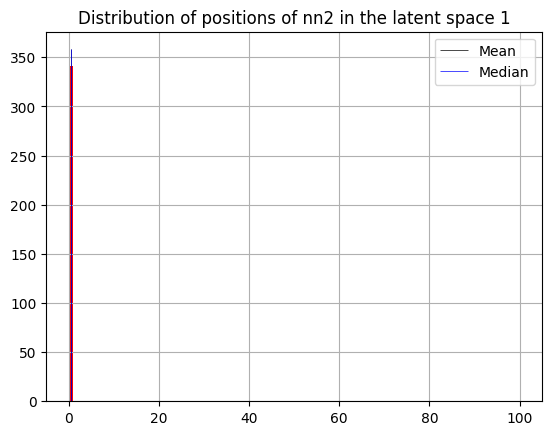

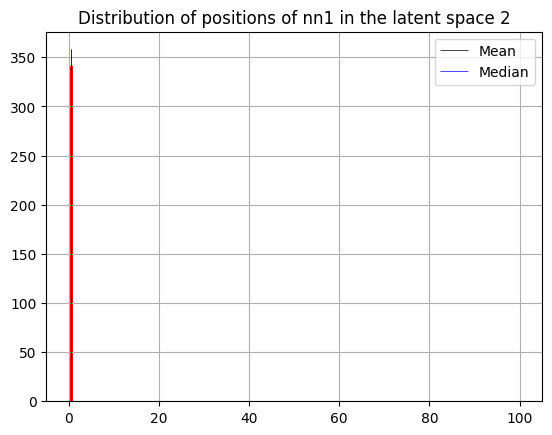

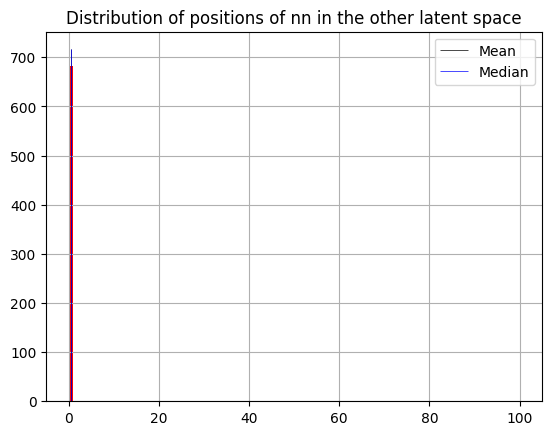

In [33]:
get_percentile_histograms(dist_mat1, dist_mat2, embeddings1, embeddings2, separate=True,
show_average=True)
plt.figure()
get_percentile_histograms(dist_mat1, dist_mat2, embeddings1, embeddings2, separate=False,
show_average=True)